# Habitable Exoplanets
We're using the dataset of confirmed exoplanets from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag%20%3E0) to find potentially habitable exoplanets. Habitability in our case is only determined basically by the planet having a temperature where liquid water could exist on the surface. Column definitions are found [here](https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html).

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [3]:
planets = pd.read_csv('exoplanets.csv', header=98)
planets.head()

,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,Xinglong Station,Published Confirmed,0,...,-0.023,2.282,0.346,-0.346,4.44038,0.003848,-0.003848,2014-05-14,2008-01,2014-05-14
1,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,Thueringer Landessternwarte Tautenburg,Published Confirmed,0,...,-0.005,1.939,0.270,-0.270,4.56216,0.003903,-0.003903,2018-09-04,2017-03,2018-09-06
2,14 And b,14 And,1,1,1,Radial Velocity,2008,Okayama Astrophysical Observatory,Published Confirmed,0,...,-0.023,2.331,0.240,-0.240,4.91781,0.002826,-0.002826,2014-05-14,2008-12,2014-05-14
3,14 Her b,14 Her,1,1,2,Radial Velocity,2002,W. M. Keck Observatory,Published Confirmed,0,...,-0.023,4.714,0.016,-0.016,6.38300,0.000351,-0.000351,2022-09-19,2022-09,2022-09-19
4,16 Cyg B b,16 Cyg B,1,3,1,Radial Velocity,1996,Multiple Observatories,Published Confirmed,0,...,-0.016,4.651,0.016,-0.016,6.06428,0.000603,-0.000603,2018-09-04,2017-03,2018-09-06


[]

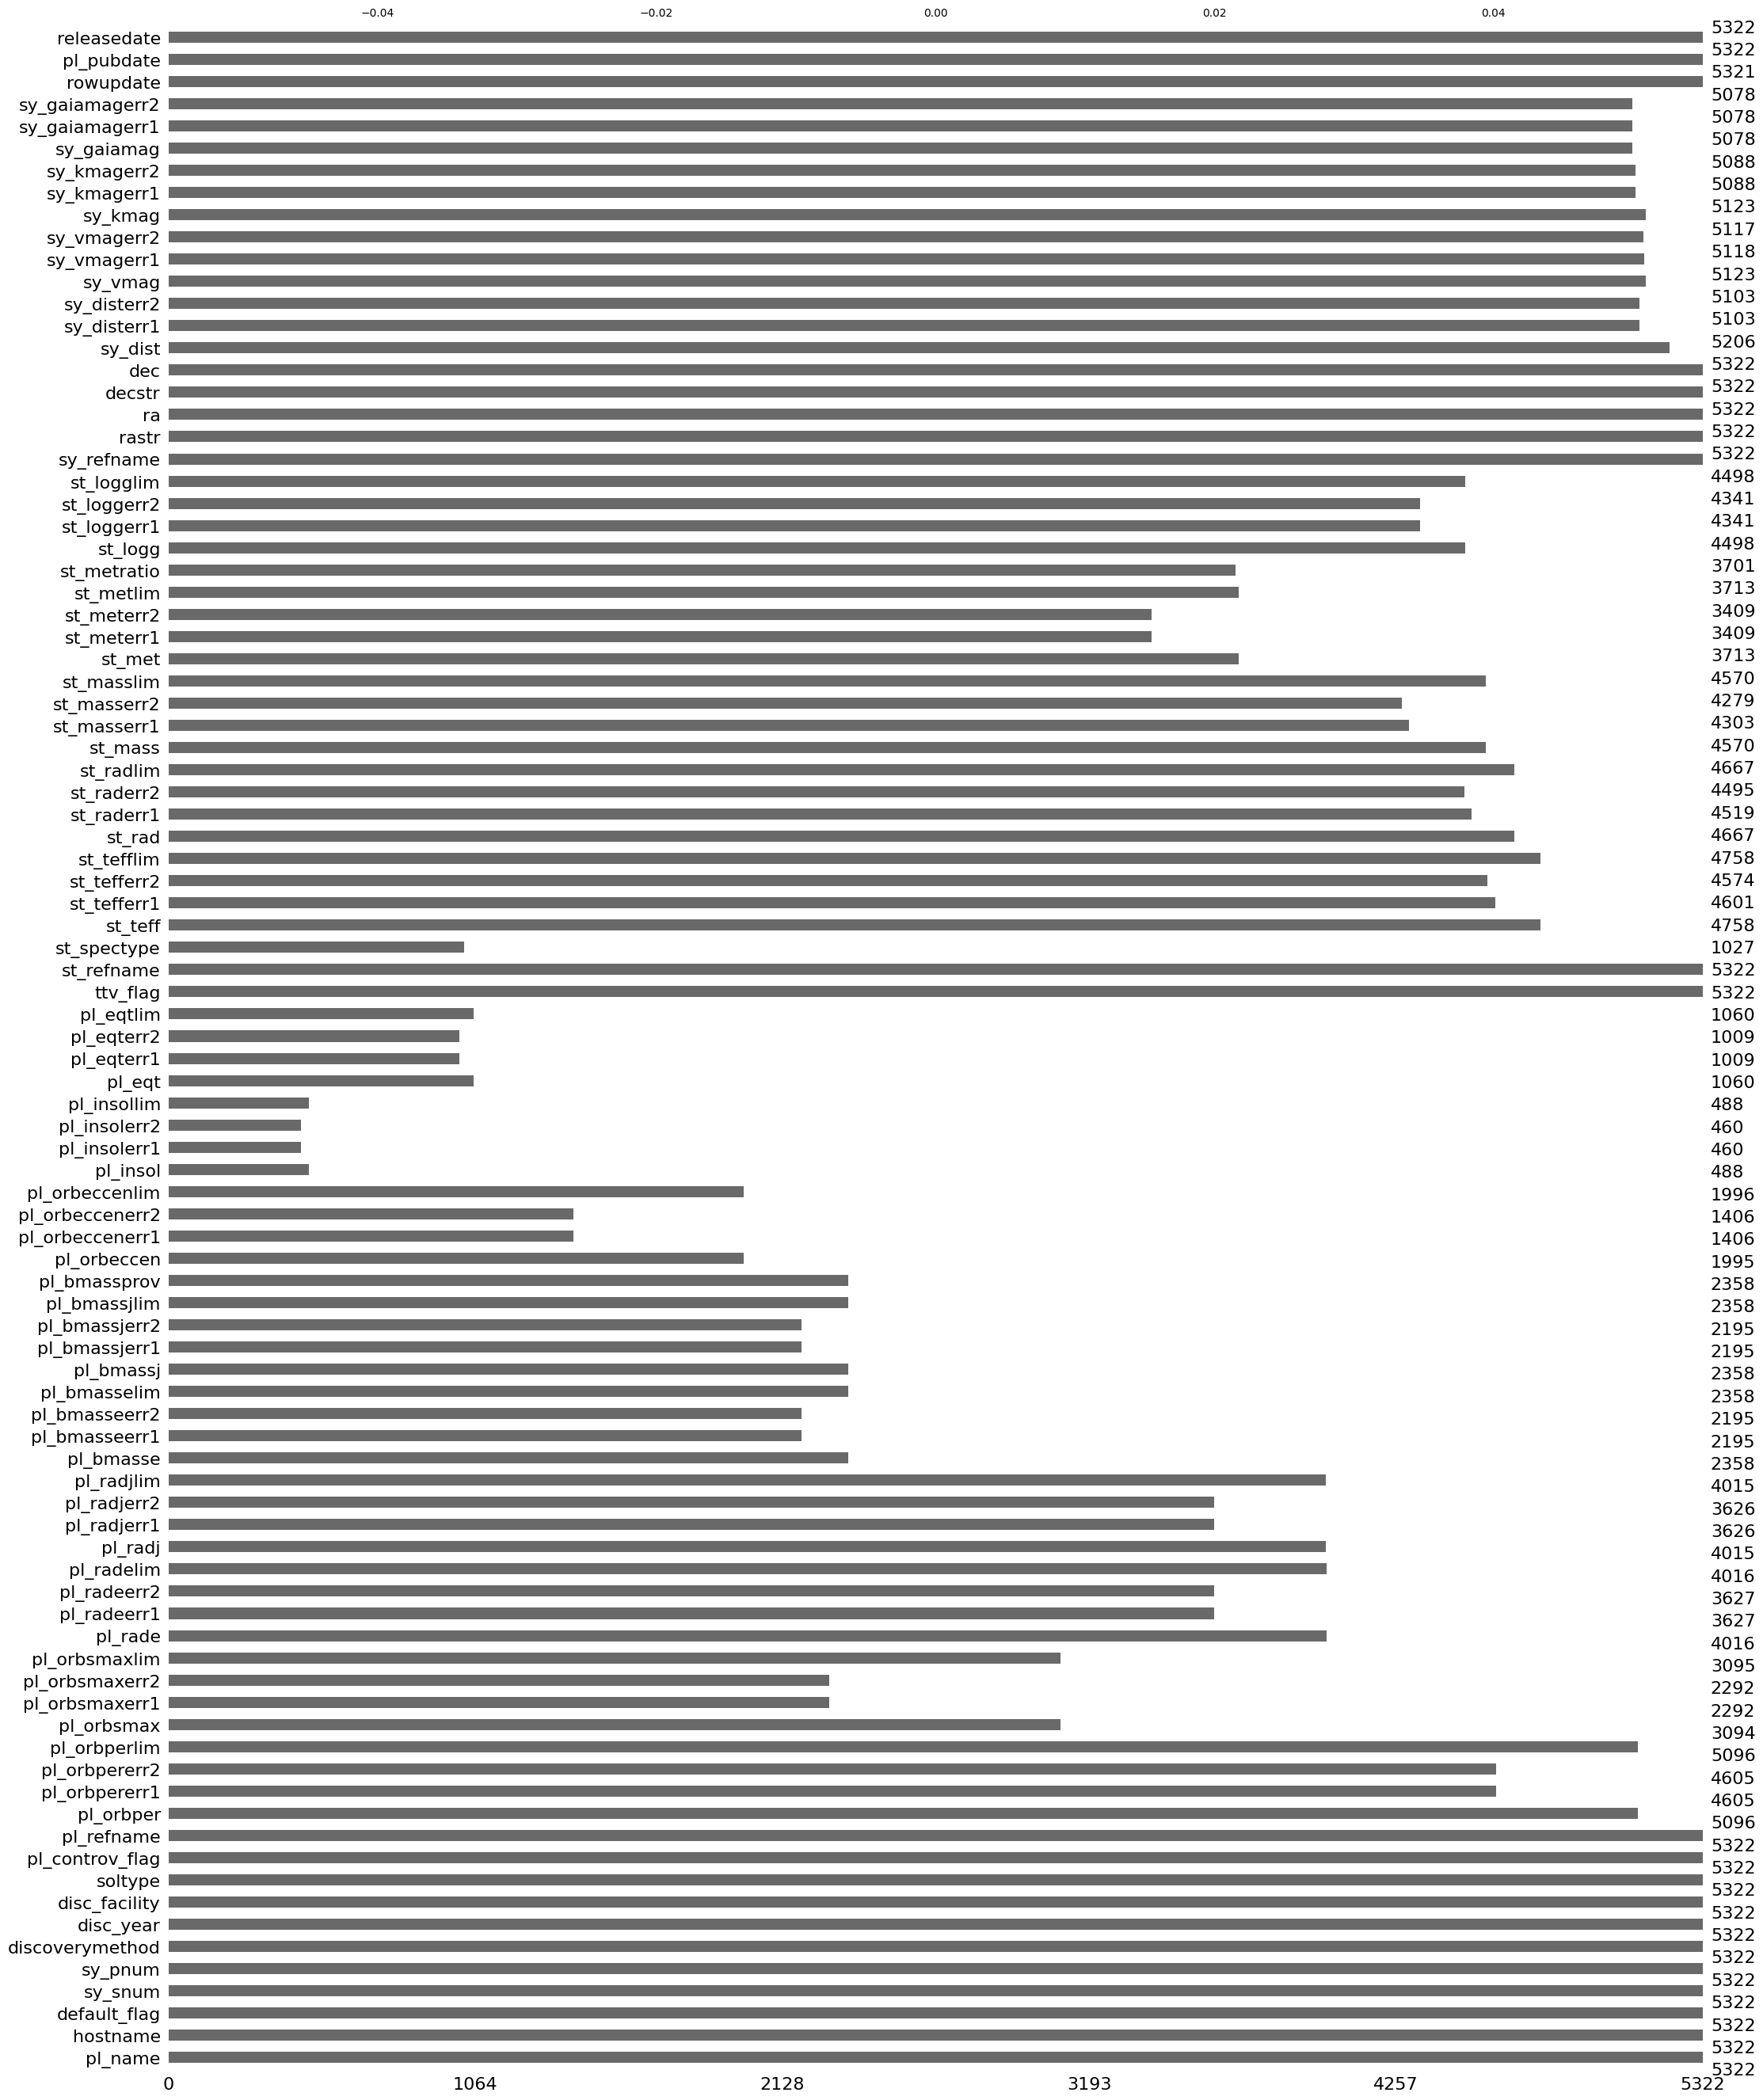

In [11]:
# look at missing data for each column
msno.bar(planets)
plt.plot()

In [13]:
# here I'm just grabbing columns which seem to have a decent amount of data and/or could be interesting to analyze later
hab_cols = ['pl_name', 'discoverymethod','pl_orbsmax','pl_eqt', 'pl_insol', 'pl_bmasse', 'pl_rade', 'pl_orbper', 
            'hostname', 'st_teff', 'st_rad', 'st_logg', 'st_met', 'st_mass', 'sy_pnum', 'sy_snum']
hab = planets[hab_cols]
hab.head()

,pl_name,discoverymethod,pl_orbsmax,pl_eqt,pl_insol,pl_bmasse,pl_rade,pl_orbper,hostname,st_teff,st_rad,st_logg,st_met,st_mass,sy_pnum,sy_snum
0,11 Com b,Radial Velocity,1.290000,NaN,NaN,6165.60000,NaN,326.030000,11 Com,4742.0,19.00,2.31,-0.35,2.70,1,2
1,11 UMi b,Radial Velocity,1.530000,NaN,NaN,4684.81420,NaN,516.219970,11 UMi,4213.0,29.79,1.93,-0.02,2.78,1,1
2,14 And b,Radial Velocity,0.830000,NaN,NaN,1525.50000,NaN,185.840000,14 And,4813.0,11.00,2.63,-0.24,2.20,1,1
3,14 Her b,Radial Velocity,2.773069,NaN,NaN,2586.74645,NaN,1765.038901,14 Her,NaN,NaN,NaN,NaN,0.91,2,1
4,16 Cyg B b,Radial Velocity,1.660000,NaN,NaN,565.73740,NaN,798.500000,16 Cyg B,5750.0,1.13,4.36,0.06,1.08,1,3


In [16]:
display(hab.isna().sum())
print("Total planets: ", len(hab))

pl_name               0
discoverymethod       0
pl_orbsmax         2228
pl_eqt             4262
pl_insol           4834
pl_bmasse          2964
pl_rade            1306
pl_orbper           226
hostname              0
st_teff             564
st_rad              655
st_logg             824
st_met             1609
st_mass             752
sy_pnum               0
sy_snum               0
dtype: int64

Total planets:  5322


In [17]:
# get number of rows with each type of discovery method
hab['discoverymethod'].value_counts()

Transit                          3982
Radial Velocity                  1032
Microlensing                      181
Imaging                            64
Transit Timing Variations          25
Eclipse Timing Variations          17
Orbital Brightness Modulation       9
Pulsar Timing                       7
Astrometry                          2
Pulsation Timing Variations         2
Disk Kinematics                     1
Name: discoverymethod, dtype: int64

In [18]:
# using the formula found here https://www.astro.princeton.edu/~strauss/FRS113/writeup3/
# takes into account the size and temperature of the star as well as how far away from the star the planet is
def calcTemp(st_temp, st_rad, sma):
    sunRadius = 695700
    st_rad = st_rad * sunRadius
    au = 1.5e8
    sma = sma * au
    albedo = 0.3
    pl_temp = st_temp * ((1-albedo)**0.25) * ((st_rad/(2*sma))**0.5)
    return pl_temp

In [20]:
# create calculated temperature column
hab['pl_calc_temp'] = calcTemp(hab['st_teff'], hab['st_rad'], hab['pl_orbsmax'])

/var/folders/7r/1k5_crzn4pg__hyvxlp5zk_80000gn/T/ipykernel_6957/3932613760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hab['pl_calc_temp'] = calcTemp(hab['st_teff'], hab['st_rad'], hab['pl_orbsmax'])


In [22]:
# look at rows without missing values for pl_eqt and pl_calc_temp
hab[hab['pl_eqt'].notna() & hab['pl_calc_temp'].notna()].head()

# a bit different for pl_eqt and pl_calc_temp, maybe units are different?

,pl_name,discoverymethod,pl_orbsmax,pl_eqt,pl_insol,pl_bmasse,pl_rade,pl_orbper,hostname,st_teff,st_rad,st_logg,st_met,st_mass,sy_pnum,sy_snum,pl_calc_temp
11,2M0437 b,Imaging,118.0000,1450.0,NaN,1271.31363,NaN,NaN,2MASS J04372171+2651014,3100.0,0.84,4.50,0.01,0.17,1,1,11.520868
45,AF Lep b,Imaging,7.9900,1400.0,NaN,1664.46737,NaN,7.520000e+03,AF Lep,6100.0,1.25,4.40,NaN,1.20,1,1,106.276278
61,BD+60 1417 b,Imaging,1662.0000,1303.0,NaN,4767.42610,14.684,NaN,BD+60 1417,4993.0,0.80,4.55,NaN,1.00,1,1,4.825207
73,CD Cet b,Radial Velocity,0.0185,464.0,8.6,3.95000,NaN,2.290700e+00,CD Cet,3130.0,0.17,4.93,0.13,0.16,1,1,417.934110
75,CFHTWIR-Oph 98 b,Imaging,200.0000,1800.0,NaN,2479.06157,20.849,8.040000e+06,CFHTWIR-Oph 98 A,2320.0,0.24,3.85,NaN,0.01,1,1,3.540002


In [28]:
# check habitability (potential) based off of pl_eqt or pl_insol (implement pl_calc_temp once unit stuff confirmed)
hab['habitable'] = ((hab['pl_eqt'] > 180) & (hab['pl_eqt'] < 310)) | ((hab['pl_insol'] > 0.25) & (hab['pl_insol'] < 2.2))

/var/folders/7r/1k5_crzn4pg__hyvxlp5zk_80000gn/T/ipykernel_6957/3852115769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hab['habitable'] = ((hab['pl_eqt'] > 180) & (hab['pl_eqt'] < 310)) | ((hab['pl_insol'] > 0.25) & (hab['pl_insol'] < 2.2))


In [29]:
# should be getting close to their number, like 360
hab['habitable'].sum()

71

### Future Ideas
* Carson's ideas
* Look at seeing if there are trends in stars that have habitable exoplanets to try and find stars to look for exoplanets